# Cell Population Analysis
This Jupyter Notebook contains code to analyze cell populations given in the file cell-count.csv. There are two parts, 1: computing the relative frequencies and generating the output .csv file, and 2: patient response analysis.

To recreate my outputs, ensure that the input file "cell-count.csv" is in the same directory, then run all cells.

### Part 1: Compute the Relative Frequencies

In [9]:
import pandas as pd

In [10]:
cellCountDF = pd.read_csv("cell-count.csv")

#### Generate the output data:
I created a small array of each cell's populations to elegantly access the data frame for the computation of total and relative frequency for each sample.

From there, we simply need to query the data from the cell count dataframe.

In [11]:
# Collecting the output in a list is more computationally friendly than in a dataframe
outputData = []
populations = ['b_cell', 'cd8_t_cell', 'cd4_t_cell', 'nk_cell', 'monocyte']
for _, sample in cellCountDF.iterrows():
  total = 0

  for population in populations:
    total += sample[population]

  for population in populations:
    outputData.append([
        sample['sample'],
        total,
        population,
        sample[population],
        round((sample[population] / total * 100), 2)
    ])

freqDF = pd.DataFrame(outputData, columns=['sample', 'total_count', 'population', 'count', 'percentage'])

Because this type of data may be used in high-stakes contexts like medicine/clinical trials, I included a few tests to ensure consistency and correctness of the output before analysis.

In [12]:
'''Agreement tests, ensuring internal consistency (not necessarily correctness)'''

# Ensure that total_count agrees with the sum of each sample's population counts
for sample_id in freqDF['sample'].unique():
  sample_rows = freqDF[freqDF['sample'] == sample_id]
  total = sample_rows['total_count'].values[0]
  count_sum = sample_rows['count'].sum()
  assert total == count_sum, f"Mismatch in total for {sample_id}"


# Ensure that every percentage adds up to 100, also checks for floating point inaccuracy
for sample_id in freqDF['sample'].unique():
  sample_rows = freqDF[freqDF['sample'] == sample_id]
  percentage_sum = sample_rows['percentage'].sum()
  assert percentage_sum == 100, f"Mismatch in percentages for {sample_id}"

'''Correctness test'''

# Ensure that s9's total and relative frequencies are as expected per the input
s9 = freqDF[freqDF['sample'] == 's9']
assert(s9['total_count'].values[0] == 130000)

expectedFrequencies = [
    round(45500 / 130000 * 100, 2),
    round(27300 / 130000 * 100, 2),
    round(32500 / 130000 * 100, 2),
    round(6500 / 130000 * 100, 2),
    round(18200 / 130000 * 100, 2)
    ]

assert(s9['percentage'].tolist() == expectedFrequencies)

Finally, generate the output file.

In [13]:
freqDF.to_csv('relativeFrequencies.csv', index=False)

### Part 2: Patient Response Analysis
At a high level, the following code filters the dataset according to the given specifications, then groups the resulting immune cell percentage data into each population's 'y' (responder) and 'n' (non-responder) categories. Once grouped, the data is ready for statsitical analysis and visualization using boxplots

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

Matplotlib is building the font cache; this may take a moment.


First, filter the samples based on:
```
condition = 'melanoma'
treatment = 'tr1'
sample_type = 'PBMC'

```
Then, split the qulifying samples into their respective response: yes samples and no samples.

In [15]:
filteredSamples = cellCountDF[
    (cellCountDF['condition'] == 'melanoma') &
    (cellCountDF['treatment'] == 'tr1') &
    (cellCountDF['sample_type'] == 'PBMC')
]

yesSamples = filteredSamples[filteredSamples['response'] == 'y']
noSamples = filteredSamples[filteredSamples['response'] == 'n']

yesData = freqDF[freqDF['sample'].isin(yesSamples['sample'])]
noData = freqDF[freqDF['sample'].isin(noSamples['sample'])]

Validate the data with a few tests

In [16]:
# Agreement tests: Ensure the 'yes' data and 'no' data sets behave as expected
expectedYes = set(cellCountDF[cellCountDF['response'] == 'y']['sample'])
expectedNo = set(cellCountDF[cellCountDF['response'] == 'n']['sample'])
actualYes = set(yesData['sample'])
actualNo = set(noData['sample'])

assert(actualYes.issubset(expectedYes))
assert(actualNo.issubset(expectedNo))

assert(actualYes.isdisjoint(actualNo) and
       actualYes.isdisjoint(expectedNo) and
       actualNo.isdisjoint(expectedYes))


# Ensure the 'yes' data and 'no' data contain only qualifying samples based on known information
qualifyingSamples = set(
    ['s1', 's2', 's3', 's5', 's6', 's12', 's13', 's16', 's17']
)

assert(set(yesData['sample']).issubset(qualifyingSamples))
assert(set(noData['sample']).issubset(qualifyingSamples))
assert(set(yesData['sample']).union(set(noData['sample'])) == qualifyingSamples)

For each sample, group its population's relative frequencies into the correct population

In [17]:
populationData = {
    'b_cell': {'y': [], 'n': []},
    'cd8_t_cell': {'y': [], 'n': []},
    'cd4_t_cell': {'y': [], 'n': []},
    'nk_cell': {'y': [], 'n': []},
    'monocyte': {'y': [], 'n': []}
}

for _, row in yesData.iterrows():
  populationData[row['population']]['y'].append(row['percentage'])

for _, row in noData.iterrows():
  populationData[row['population']]['n'].append(row['percentage'])

Now that the data is prepared, we can generate the plots

Yes : [30.0, 30.0, 28.0, 33.0, 27.0, 27.0]
No : [40.0, 25.0, 14.0]


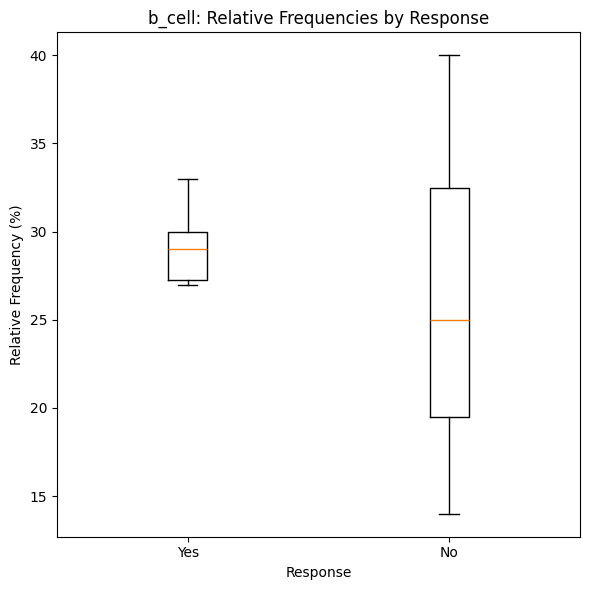


Yes : [20.0, 22.0, 21.0, 19.0, 21.0, 20.0]
No : [20.0, 22.0, 20.0]


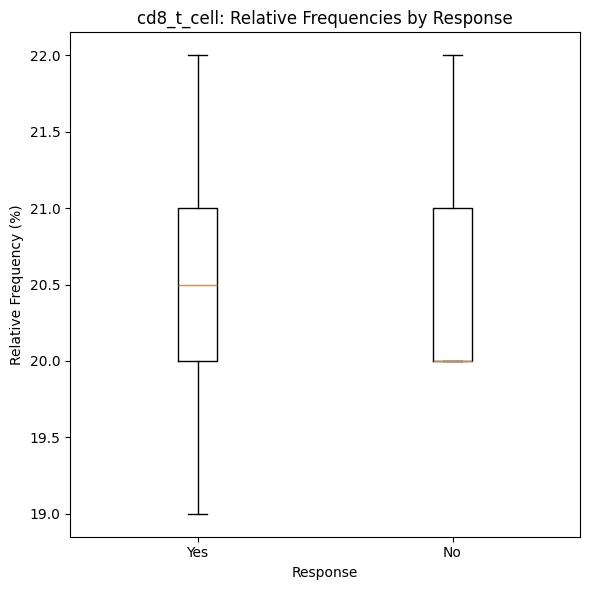


Yes : [35.0, 40.0, 30.0, 38.0, 41.0, 34.0]
No : [25.0, 30.0, 24.0]


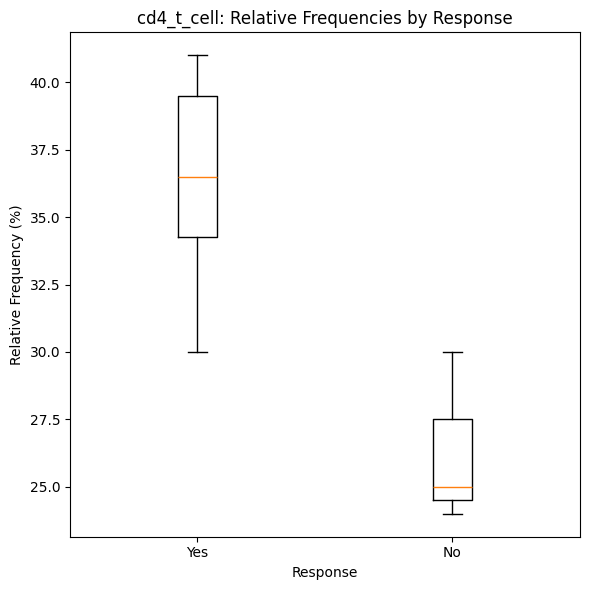


Yes : [5.0, 2.0, 8.0, 5.0, 7.0, 9.0]
No : [3.0, 5.0, 4.0]


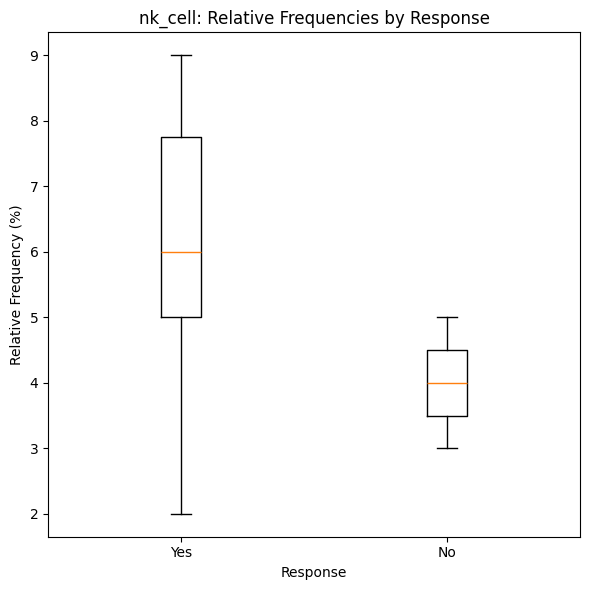


Yes : [10.0, 6.0, 13.0, 5.0, 4.0, 10.0]
No : [12.0, 18.0, 38.0]


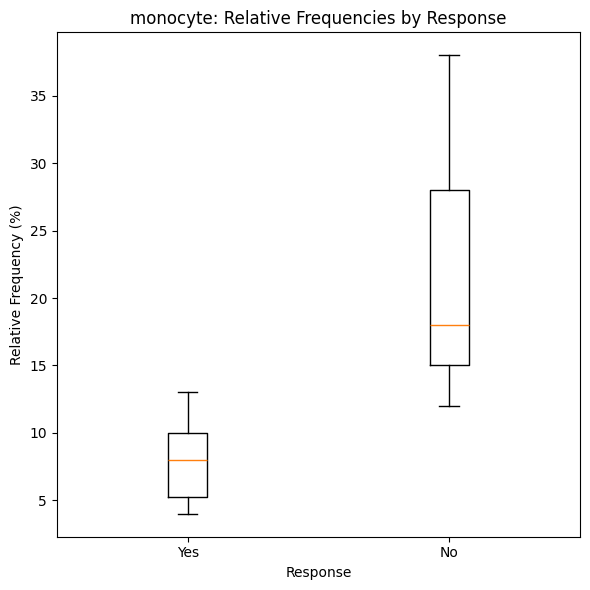

In [18]:
for population in populationData:
  fig, ax = plt.subplots(figsize=(6, 6))
  ax.boxplot([populationData[population]['y'], populationData[population]['n']])

  ax.set_xticklabels(['Yes', 'No'])
  ax.set_xlabel('Response')
  ax.set_ylabel('Relative Frequency (%)')
  ax.set_title(f'{population}: Relative Frequencies by Response')

  # These print statements can be uncommented to verify that the boxplot labels are correct
  print(f"Yes : {populationData[population]['y']}")
  print(f"No : {populationData[population]['n']}")

  plt.tight_layout()
  plt.show()
  print()

### Hypothesis:

Based on the boxplots, the populations `cd4_t_cell`, `nk_cell`, and `monocyte` appear to differ notably between responders and non-responders. However, `nk_cell` shows more whisker overlap than the other two mentioned cells and is therefore unlikely to meet the threshold for statistical significance.

To assess this hypothesis, I'll use a formal statistical test. Because the distributions are not necessarily normal, the appropriate test is the Mann-Whitney U test.

In [19]:
from scipy.stats import mannwhitneyu

for population in populations:
  u_statistic, p_value = mannwhitneyu(
      populationData[population]['y'],
      populationData[population]['n'],
      alternative='two-sided'
      )

  print(f"Population: {population}")
  print(f"Responders data: {populationData[population]['y']}")
  print(f"Non-responderes data: {populationData[population]['n']}")
  print(f"P-value: {p_value:.3f}")

  # Check significance
  alpha = 0.05
  if p_value < alpha:
      print("Statistically significant difference!")
  else:
      print("No statistically significant difference")

  print()

Population: b_cell
Responders data: [30.0, 30.0, 28.0, 33.0, 27.0, 27.0]
Non-responderes data: [40.0, 25.0, 14.0]
P-value: 0.515
No statistically significant difference

Population: cd8_t_cell
Responders data: [20.0, 22.0, 21.0, 19.0, 21.0, 20.0]
Non-responderes data: [20.0, 22.0, 20.0]
P-value: 1.000
No statistically significant difference

Population: cd4_t_cell
Responders data: [35.0, 40.0, 30.0, 38.0, 41.0, 34.0]
Non-responderes data: [25.0, 30.0, 24.0]
P-value: 0.038
Statistically significant difference!

Population: nk_cell
Responders data: [5.0, 2.0, 8.0, 5.0, 7.0, 9.0]
Non-responderes data: [3.0, 5.0, 4.0]
P-value: 0.237
No statistically significant difference

Population: monocyte
Responders data: [10.0, 6.0, 13.0, 5.0, 4.0, 10.0]
Non-responderes data: [12.0, 18.0, 38.0]
P-value: 0.052
No statistically significant difference



### Conclusion:

The Mann-Whitney U tests show that only the ```cd4_t_cell``` population exhibits a statistically significant difference between responders and non-responders (p = 0.038). This level of confidence suggests that the ```cd4_t_cell``` population's relative frequency is meaningfully associated with treatment response.

Although the ```nk_cell``` and ```monocyte``` populations seemed to suggest significant difference from the boxplots, ```nk_cell``` failed to reach significance, likely due to a potential outlier (2.0) among responders, while ```monocyte``` was borderline significant (p = 0.052). A larger sample size could reveal a stronger difference between responses, and help us determine if 2.0 truly is an outlier in ```nk_cell```'s responders.

While further study is required to determine if the relative frequency of the ```nk_cell``` and ```monocyte``` populations could be reliable in predicting patient response, the ```cd4_t_cell``` population's relative frequency shows huge promise in predicting melanoma patients' response to tr1. As a next step, performing a regression analysis on the ```cd4_t_cell``` population could provide more insight into its predictive strength.

-----------------------------------------------

Thank you for your time! This was a really fun and interesting assignment, and I would love to expand my expertise in pandas and tabular data while concurrently learning about a topic as fascinating as cytometry at Teiko.